In [61]:
#Save con Nodos
import os
from keras.models import load_model
import itertools
from matplotlib import pyplot as plt
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os, sys
dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from sklearn.utils import class_weight
import numpy as np

from evaluation import calculate_metrics
from sklearn.metrics import confusion_matrix,accuracy_score
import pandas as pd
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
import random
from random import shuffle,seed
from sklearn.metrics import classification_report
import math
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler,EarlyStopping,ReduceLROnPlateau
from keras.backend import eval



In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import time

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model.add(MaxPooling2D((2,2), strides=(1,1)))
model.add(Dropout(0.1))
model.add(Conv2D(128, (5, 5), strides=(1, 1), activation="relu", padding="same"))
model.add(Conv2D(256, (5, 5), strides=(1, 1), activation="relu", padding="same"))
#model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 256)       819456    
_________________________________________________________________
global_average_poolin

In [4]:
model1 = Sequential()
model1.add(Conv2D(64, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model1.add(MaxPooling2D((2,2)))
model1.add(Dropout(0.1))
model1.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model1.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="same"))
#model1.add(Flatten())
model1.add(GlobalAveragePooling2D())
model1.add(Dense(256,activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()

model1.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 15, 15, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
__________

In [4]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets_unb.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

,KOI Name,Set
0,K00889.01,Test
1,K01009.01,Train
2,K07621.01,Train
3,K06252.01,Train
4,K00958.01,Unlabeled


In [5]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.53594,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
2,K07621.01,FALSE POSITIVE,NaN,275.073650,315.24860,2455148.249,0.595,3.37000,228.9,0.014,...,5604.0,4.226,-0.12,1.187,0.864,5.909,8.012,7.5,1,4
3,K06252.01,FALSE POSITIVE,NaN,8.460439,133.77449,2454966.774,1.061,4.73492,76412.9,0.478,...,5951.0,4.638,-1.06,0.702,0.796,452.526,3704.503,1797.4,1,164
6,K04162.01,FALSE POSITIVE,NaN,0.539366,131.97457,2454964.975,0.988,5.43400,145.0,0.016,...,6341.0,3.301,-0.10,5.302,2.050,4.847,9.076,57.6,1,1239
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.03900,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9


In [6]:
kois_train=df_meta_train['KOI Name'].values
labels_train=df_meta_train['NExScI Disposition'].values
kois_val=df_meta_test['KOI Name'].values
labels_val=df_meta_test['NExScI Disposition'].values
kois_test=df_meta_unb['KOI Name'].values
labels_test=df_meta_unb['NExScI Disposition'].values

In [7]:
labels_train[:5]

array(['FALSE POSITIVE', 'FALSE POSITIVE', 'FALSE POSITIVE',
       'FALSE POSITIVE', 'FALSE POSITIVE'], dtype=object)

In [8]:
def to_int(labels):
    y_true=[]
    for y in labels:
        if y=='CONFIRMED':
            y_true.append(1)
        else:
            y_true.append(0)
    return y_true

In [9]:
y_train=to_int(labels_train)
y_val=to_int(labels_val)

In [10]:
y_train[:6]

[0, 0, 0, 0, 0, 1]

In [11]:
folder_fp='/work/work_teamEXOPLANET/MTF/falsos_positivos/'
folder_c='/work/work_teamEXOPLANET/MTF_gabo/'
falsos=os.listdir(folder_fp)
confirmed=os.listdir(folder_c+'confirmados')
candidates=os.listdir(folder_c+'candidatos')
#load data
x_train=[]
i=0
for koi in kois_train:
    print ("Cargando objeto", koi, 'con ientificador',i)
    if labels_train[i]=='FALSE POSITIVE':
        x_train.append(np.load(folder_fp+koi+'.npy'))
    else:
        x_train.append(np.load(folder_c+'confirmados/'+koi+'.npy'))
    i+=1
 

Cargando objeto K01009.01 con ientificador 0
Cargando objeto K07621.01 con ientificador 1
Cargando objeto K06252.01 con ientificador 2
Cargando objeto K04162.01 con ientificador 3
Cargando objeto K00998.01 con ientificador 4
Cargando objeto K00992.01 con ientificador 5
Cargando objeto K00982.01 con ientificador 6
Cargando objeto K03924.01 con ientificador 7
Cargando objeto K07623.01 con ientificador 8
Cargando objeto K00362.01 con ientificador 9
Cargando objeto K03658.01 con ientificador 10
Cargando objeto K00993.01 con ientificador 11
Cargando objeto K00993.02 con ientificador 12
Cargando objeto K00993.03 con ientificador 13
Cargando objeto K01008.01 con ientificador 14
Cargando objeto K04224.01 con ientificador 15
Cargando objeto K04212.01 con ientificador 16
Cargando objeto K01007.01 con ientificador 17
Cargando objeto K04925.01 con ientificador 18
Cargando objeto K07625.01 con ientificador 19
Cargando objeto K04927.01 con ientificador 20
Cargando objeto K01001.01 con ientificador 2

Cargando objeto K00045.01 con ientificador 391
Cargando objeto K00442.01 con ientificador 392
Cargando objeto K00442.02 con ientificador 393
Cargando objeto K00442.03 con ientificador 394
Cargando objeto K01212.01 con ientificador 395
Cargando objeto K07544.01 con ientificador 396
Cargando objeto K07544.02 con ientificador 397
Cargando objeto K02308.01 con ientificador 398
Cargando objeto K07665.01 con ientificador 399
Cargando objeto K05005.01 con ientificador 400
Cargando objeto K04057.01 con ientificador 401
Cargando objeto K03402.01 con ientificador 402
Cargando objeto K00208.01 con ientificador 403
Cargando objeto K03963.01 con ientificador 404
Cargando objeto K02141.01 con ientificador 405
Cargando objeto K06359.01 con ientificador 406
Cargando objeto K06360.01 con ientificador 407
Cargando objeto K00806.01 con ientificador 408
Cargando objeto K00806.02 con ientificador 409
Cargando objeto K00027.01 con ientificador 410
Cargando objeto K00443.01 con ientificador 411
Cargando obje

Cargando objeto K01327.01 con ientificador 608
Cargando objeto K06410.01 con ientificador 609
Cargando objeto K07692.01 con ientificador 610
Cargando objeto K02987.01 con ientificador 611
Cargando objeto K04712.01 con ientificador 612
Cargando objeto K06411.01 con ientificador 613
Cargando objeto K03378.01 con ientificador 614
Cargando objeto K06412.01 con ientificador 615
Cargando objeto K07548.01 con ientificador 616
Cargando objeto K04474.01 con ientificador 617
Cargando objeto K07695.01 con ientificador 618
Cargando objeto K06414.01 con ientificador 619
Cargando objeto K00496.01 con ientificador 620
Cargando objeto K02245.01 con ientificador 621
Cargando objeto K01332.01 con ientificador 622
Cargando objeto K01332.02 con ientificador 623
Cargando objeto K01332.03 con ientificador 624
Cargando objeto K06417.01 con ientificador 625
Cargando objeto K02303.01 con ientificador 626
Cargando objeto K06114.01 con ientificador 627
Cargando objeto K03295.01 con ientificador 628
Cargando obje

Cargando objeto K00108.02 con ientificador 784
Cargando objeto K02635.01 con ientificador 785
Cargando objeto K06470.01 con ientificador 786
Cargando objeto K02617.01 con ientificador 787
Cargando objeto K06472.01 con ientificador 788
Cargando objeto K03212.01 con ientificador 789
Cargando objeto K01664.01 con ientificador 790
Cargando objeto K04018.01 con ientificador 791
Cargando objeto K06473.01 con ientificador 792
Cargando objeto K03453.01 con ientificador 793
Cargando objeto K06474.01 con ientificador 794
Cargando objeto K06122.01 con ientificador 795
Cargando objeto K03743.01 con ientificador 796
Cargando objeto K00820.01 con ientificador 797
Cargando objeto K03290.01 con ientificador 798
Cargando objeto K01873.01 con ientificador 799
Cargando objeto K01873.02 con ientificador 800
Cargando objeto K01561.01 con ientificador 801
Cargando objeto K05108.01 con ientificador 802
Cargando objeto K04658.01 con ientificador 803
Cargando objeto K05109.01 con ientificador 804
Cargando obje

Cargando objeto K02440.01 con ientificador 1001
Cargando objeto K04199.01 con ientificador 1002
Cargando objeto K06565.01 con ientificador 1003
Cargando objeto K06566.01 con ientificador 1004
Cargando objeto K06567.01 con ientificador 1005
Cargando objeto K02555.01 con ientificador 1006
Cargando objeto K04008.01 con ientificador 1007
Cargando objeto K00408.01 con ientificador 1008
Cargando objeto K00408.02 con ientificador 1009
Cargando objeto K00408.03 con ientificador 1010
Cargando objeto K00408.04 con ientificador 1011
Cargando objeto K00408.05 con ientificador 1012
Cargando objeto K00644.01 con ientificador 1013
Cargando objeto K00188.01 con ientificador 1014
Cargando objeto K00829.01 con ientificador 1015
Cargando objeto K00829.02 con ientificador 1016
Cargando objeto K00829.03 con ientificador 1017
Cargando objeto K00830.01 con ientificador 1018
Cargando objeto K06569.01 con ientificador 1019
Cargando objeto K03768.01 con ientificador 1020
Cargando objeto K03289.01 con ientificad

Cargando objeto K08104.01 con ientificador 1219
Cargando objeto K00555.01 con ientificador 1220
Cargando objeto K07737.01 con ientificador 1221
Cargando objeto K00272.01 con ientificador 1222
Cargando objeto K00033.01 con ientificador 1223
Cargando objeto K06620.01 con ientificador 1224
Cargando objeto K00206.01 con ientificador 1225
Cargando objeto K07738.01 con ientificador 1226
Cargando objeto K01956.01 con ientificador 1227
Cargando objeto K03603.01 con ientificador 1228
Cargando objeto K06621.01 con ientificador 1229
Cargando objeto K05196.01 con ientificador 1230
Cargando objeto K00148.01 con ientificador 1231
Cargando objeto K00148.02 con ientificador 1232
Cargando objeto K00148.03 con ientificador 1233
Cargando objeto K06622.01 con ientificador 1234
Cargando objeto K07739.01 con ientificador 1235
Cargando objeto K00556.01 con ientificador 1236
Cargando objeto K03676.01 con ientificador 1237
Cargando objeto K06134.01 con ientificador 1238
Cargando objeto K03288.01 con ientificad

Cargando objeto K00846.01 con ientificador 1408
Cargando objeto K00658.01 con ientificador 1409
Cargando objeto K00658.02 con ientificador 1410
Cargando objeto K00658.03 con ientificador 1411
Cargando objeto K06659.01 con ientificador 1412
Cargando objeto K03649.01 con ientificador 1413
Cargando objeto K01045.01 con ientificador 1414
Cargando objeto K01057.01 con ientificador 1415
Cargando objeto K05236.01 con ientificador 1416
Cargando objeto K07761.01 con ientificador 1417
Cargando objeto K00306.01 con ientificador 1418
Cargando objeto K03070.01 con ientificador 1419
Cargando objeto K06662.01 con ientificador 1420
Cargando objeto K03004.01 con ientificador 1421
Cargando objeto K02098.01 con ientificador 1422
Cargando objeto K04087.01 con ientificador 1423
Cargando objeto K06663.01 con ientificador 1424
Cargando objeto K06664.01 con ientificador 1425
Cargando objeto K07763.01 con ientificador 1426
Cargando objeto K03134.01 con ientificador 1427
Cargando objeto K06019.01 con ientificad

Cargando objeto K00560.01 con ientificador 1623
Cargando objeto K01790.01 con ientificador 1624
Cargando objeto K02455.01 con ientificador 1625
Cargando objeto K00416.02 con ientificador 1626
Cargando objeto K03818.01 con ientificador 1627
Cargando objeto K08123.01 con ientificador 1628
Cargando objeto K07782.01 con ientificador 1629
Cargando objeto K00041.01 con ientificador 1630
Cargando objeto K00041.02 con ientificador 1631
Cargando objeto K00041.03 con ientificador 1632
Cargando objeto K06721.01 con ientificador 1633
Cargando objeto K08124.01 con ientificador 1634
Cargando objeto K06722.01 con ientificador 1635
Cargando objeto K00855.01 con ientificador 1636
Cargando objeto K04574.01 con ientificador 1637
Cargando objeto K06724.01 con ientificador 1638
Cargando objeto K04882.01 con ientificador 1639
Cargando objeto K06725.01 con ientificador 1640
Cargando objeto K04483.01 con ientificador 1641
Cargando objeto K02568.01 con ientificador 1642
Cargando objeto K05293.01 con ientificad

Cargando objeto K04572.01 con ientificador 1839
Cargando objeto K03026.01 con ientificador 1840
Cargando objeto K01366.01 con ientificador 1841
Cargando objeto K01366.02 con ientificador 1842
Cargando objeto K02643.01 con ientificador 1843
Cargando objeto K03737.01 con ientificador 1844
Cargando objeto K01367.01 con ientificador 1845
Cargando objeto K06032.01 con ientificador 1846
Cargando objeto K01363.01 con ientificador 1847
Cargando objeto K07797.01 con ientificador 1848
Cargando objeto K06791.01 con ientificador 1849
Cargando objeto K02894.01 con ientificador 1850
Cargando objeto K06792.01 con ientificador 1851
Cargando objeto K08266.01 con ientificador 1852
Cargando objeto K03531.01 con ientificador 1853
Cargando objeto K00869.01 con ientificador 1854
Cargando objeto K00869.02 con ientificador 1855
Cargando objeto K00869.03 con ientificador 1856
Cargando objeto K02975.01 con ientificador 1857
Cargando objeto K05339.01 con ientificador 1858
Cargando objeto K01960.01 con ientificad

Cargando objeto K01862.01 con ientificador 2057
Cargando objeto K00877.01 con ientificador 2058
Cargando objeto K00877.02 con ientificador 2059
Cargando objeto K00877.03 con ientificador 2060
Cargando objeto K03443.01 con ientificador 2061
Cargando objeto K02539.01 con ientificador 2062
Cargando objeto K02450.01 con ientificador 2063
Cargando objeto K06035.01 con ientificador 2064
Cargando objeto K03790.01 con ientificador 2065
Cargando objeto K00878.01 con ientificador 2066
Cargando objeto K01353.01 con ientificador 2067
Cargando objeto K03250.01 con ientificador 2068
Cargando objeto K04599.01 con ientificador 2069
Cargando objeto K06861.01 con ientificador 2070
Cargando objeto K03014.01 con ientificador 2071
Cargando objeto K01368.01 con ientificador 2072
Cargando objeto K07585.01 con ientificador 2073
Cargando objeto K06865.01 con ientificador 2074
Cargando objeto K06036.01 con ientificador 2075
Cargando objeto K06866.01 con ientificador 2076
Cargando objeto K06867.01 con ientificad

Cargando objeto K04268.01 con ientificador 2275
Cargando objeto K06044.01 con ientificador 2276
Cargando objeto K01454.01 con ientificador 2277
Cargando objeto K00171.01 con ientificador 2278
Cargando objeto K03804.01 con ientificador 2279
Cargando objeto K01456.01 con ientificador 2280
Cargando objeto K00048.01 con ientificador 2281
Cargando objeto K05436.01 con ientificador 2282
Cargando objeto K06922.01 con ientificador 2283
Cargando objeto K01464.01 con ientificador 2284
Cargando objeto K04169.01 con ientificador 2285
Cargando objeto K06165.01 con ientificador 2286
Cargando objeto K06165.02 con ientificador 2287
Cargando objeto K03758.01 con ientificador 2288
Cargando objeto K00516.01 con ientificador 2289
Cargando objeto K07851.01 con ientificador 2290
Cargando objeto K01499.01 con ientificador 2291
Cargando objeto K06045.01 con ientificador 2292
Cargando objeto K01453.01 con ientificador 2293
Cargando objeto K06923.01 con ientificador 2294
Cargando objeto K06924.01 con ientificad

Cargando objeto K03074.01 con ientificador 2493
Cargando objeto K06175.01 con ientificador 2494
Cargando objeto K07871.01 con ientificador 2495
Cargando objeto K02762.01 con ientificador 2496
Cargando objeto K07872.01 con ientificador 2497
Cargando objeto K06992.01 con ientificador 2498
Cargando objeto K03405.01 con ientificador 2499
Cargando objeto K01920.01 con ientificador 2500
Cargando objeto K02133.01 con ientificador 2501
Cargando objeto K00419.01 con ientificador 2502
Cargando objeto K01069.01 con ientificador 2503
Cargando objeto K01069.02 con ientificador 2504
Cargando objeto K01767.01 con ientificador 2505
Cargando objeto K05488.01 con ientificador 2506
Cargando objeto K01910.01 con ientificador 2507
Cargando objeto K08154.01 con ientificador 2508
Cargando objeto K00906.01 con ientificador 2509
Cargando objeto K00906.02 con ientificador 2510
Cargando objeto K00906.03 con ientificador 2511
Cargando objeto K06995.01 con ientificador 2512
Cargando objeto K02238.01 con ientificad

Cargando objeto K03315.01 con ientificador 2711
Cargando objeto K02027.01 con ientificador 2712
Cargando objeto K07895.01 con ientificador 2713
Cargando objeto K00692.02 con ientificador 2714
Cargando objeto K00577.02 con ientificador 2715
Cargando objeto K02488.01 con ientificador 2716
Cargando objeto K00139.01 con ientificador 2717
Cargando objeto K00139.02 con ientificador 2718
Cargando objeto K07057.01 con ientificador 2719
Cargando objeto K07058.01 con ientificador 2720
Cargando objeto K01249.01 con ientificador 2721
Cargando objeto K02969.01 con ientificador 2722
Cargando objeto K01263.01 con ientificador 2723
Cargando objeto K07059.01 con ientificador 2724
Cargando objeto K03450.01 con ientificador 2725
Cargando objeto K00961.01 con ientificador 2726
Cargando objeto K00961.02 con ientificador 2727
Cargando objeto K00961.03 con ientificador 2728
Cargando objeto K05544.01 con ientificador 2729
Cargando objeto K01270.01 con ientificador 2730
Cargando objeto K01270.02 con ientificad

Cargando objeto K05581.01 con ientificador 2929
Cargando objeto K02224.01 con ientificador 2930
Cargando objeto K03336.01 con ientificador 2931
Cargando objeto K01844.01 con ientificador 2932
Cargando objeto K00132.01 con ientificador 2933
Cargando objeto K03106.01 con ientificador 2934
Cargando objeto K05582.01 con ientificador 2935
Cargando objeto K03789.01 con ientificador 2936
Cargando objeto K07108.01 con ientificador 2937
Cargando objeto K01414.01 con ientificador 2938
Cargando objeto K05584.01 con ientificador 2939
Cargando objeto K03754.01 con ientificador 2940
Cargando objeto K07109.01 con ientificador 2941
Cargando objeto K04758.01 con ientificador 2942
Cargando objeto K05586.01 con ientificador 2943
Cargando objeto K04784.01 con ientificador 2944
Cargando objeto K07110.01 con ientificador 2945
Cargando objeto K02517.01 con ientificador 2946
Cargando objeto K00322.01 con ientificador 2947
Cargando objeto K01387.01 con ientificador 2948
Cargando objeto K02038.01 con ientificad

Cargando objeto K00935.02 con ientificador 3147
Cargando objeto K00935.03 con ientificador 3148
Cargando objeto K03348.01 con ientificador 3149
Cargando objeto K02078.01 con ientificador 3150
Cargando objeto K02078.02 con ientificador 3151
Cargando objeto K02129.01 con ientificador 3152
Cargando objeto K07164.01 con ientificador 3153
Cargando objeto K01900.01 con ientificador 3154
Cargando objeto K03867.01 con ientificador 3155
Cargando objeto K07165.01 con ientificador 3156
Cargando objeto K07166.01 con ientificador 3157
Cargando objeto K02374.01 con ientificador 3158
Cargando objeto K02374.02 con ientificador 3159
Cargando objeto K02137.01 con ientificador 3160
Cargando objeto K03597.01 con ientificador 3161
Cargando objeto K02905.01 con ientificador 3162
Cargando objeto K00936.01 con ientificador 3163
Cargando objeto K00936.02 con ientificador 3164
Cargando objeto K08283.01 con ientificador 3165
Cargando objeto K00249.01 con ientificador 3166
Cargando objeto K05662.01 con ientificad

Cargando objeto K07217.01 con ientificador 3365
Cargando objeto K04578.01 con ientificador 3366
Cargando objeto K02272.01 con ientificador 3367
Cargando objeto K03934.01 con ientificador 3368
Cargando objeto K07218.01 con ientificador 3369
Cargando objeto K02044.01 con ientificador 3370
Cargando objeto K03543.01 con ientificador 3371
Cargando objeto K03588.01 con ientificador 3372
Cargando objeto K07956.01 con ientificador 3373
Cargando objeto K03516.01 con ientificador 3374
Cargando objeto K03647.01 con ientificador 3375
Cargando objeto K00946.01 con ientificador 3376
Cargando objeto K00179.01 con ientificador 3377
Cargando objeto K00179.02 con ientificador 3378
Cargando objeto K02654.01 con ientificador 3379
Cargando objeto K06072.01 con ientificador 3380
Cargando objeto K07221.01 con ientificador 3381
Cargando objeto K02815.01 con ientificador 3382
Cargando objeto K07222.01 con ientificador 3383
Cargando objeto K04096.01 con ientificador 3384
Cargando objeto K03729.02 con ientificad

Cargando objeto K00398.03 con ientificador 3583
Cargando objeto K03562.01 con ientificador 3584
Cargando objeto K00719.01 con ientificador 3585
Cargando objeto K00719.03 con ientificador 3586
Cargando objeto K00719.04 con ientificador 3587
Cargando objeto K07262.01 con ientificador 3588
Cargando objeto K05742.01 con ientificador 3589
Cargando objeto K00076.01 con ientificador 3590
Cargando objeto K01925.01 con ientificador 3591
Cargando objeto K04139.01 con ientificador 3592
Cargando objeto K03964.01 con ientificador 3593
Cargando objeto K05743.01 con ientificador 3594
Cargando objeto K05744.01 con ientificador 3595
Cargando objeto K07980.01 con ientificador 3596
Cargando objeto K03051.02 con ientificador 3597
Cargando objeto K03205.01 con ientificador 3598
Cargando objeto K04195.01 con ientificador 3599
Cargando objeto K03098.01 con ientificador 3600
Cargando objeto K07981.01 con ientificador 3601
Cargando objeto K05745.01 con ientificador 3602
Cargando objeto K08191.01 con ientificad

Cargando objeto K07313.01 con ientificador 3802
Cargando objeto K06220.01 con ientificador 3803
Cargando objeto K01172.01 con ientificador 3804
Cargando objeto K01155.01 con ientificador 3805
Cargando objeto K01157.01 con ientificador 3806
Cargando objeto K07314.01 con ientificador 3807
Cargando objeto K04315.01 con ientificador 3808
Cargando objeto K04547.01 con ientificador 3809
Cargando objeto K07315.01 con ientificador 3810
Cargando objeto K07316.01 con ientificador 3811
Cargando objeto K07317.01 con ientificador 3812
Cargando objeto K03756.01 con ientificador 3813
Cargando objeto K01158.01 con ientificador 3814
Cargando objeto K04832.01 con ientificador 3815
Cargando objeto K00738.01 con ientificador 3816
Cargando objeto K00738.02 con ientificador 3817
Cargando objeto K02726.01 con ientificador 3818
Cargando objeto K07318.01 con ientificador 3819
Cargando objeto K00334.01 con ientificador 3820
Cargando objeto K08004.01 con ientificador 3821
Cargando objeto K01997.01 con ientificad

Cargando objeto K02549.01 con ientificador 3996
Cargando objeto K00751.01 con ientificador 3997
Cargando objeto K02317.01 con ientificador 3998
Cargando objeto K07362.01 con ientificador 3999
Cargando objeto K02978.01 con ientificador 4000
Cargando objeto K01637.01 con ientificador 4001
Cargando objeto K07363.01 con ientificador 4002
Cargando objeto K08029.01 con ientificador 4003
Cargando objeto K07364.01 con ientificador 4004
Cargando objeto K03359.01 con ientificador 4005
Cargando objeto K07365.01 con ientificador 4006
Cargando objeto K04024.01 con ientificador 4007
Cargando objeto K06228.01 con ientificador 4008
Cargando objeto K00430.01 con ientificador 4009
Cargando objeto K00600.01 con ientificador 4010
Cargando objeto K04312.01 con ientificador 4011
Cargando objeto K02236.02 con ientificador 4012
Cargando objeto K00209.01 con ientificador 4013
Cargando objeto K00209.02 con ientificador 4014
Cargando objeto K06081.01 con ientificador 4015
Cargando objeto K06229.01 con ientificad

Cargando objeto K06235.01 con ientificador 4214
Cargando objeto K00761.01 con ientificador 4215
Cargando objeto K01647.01 con ientificador 4216
Cargando objeto K00762.01 con ientificador 4217
Cargando objeto K07414.01 con ientificador 4218
Cargando objeto K01430.01 con ientificador 4219
Cargando objeto K01430.02 con ientificador 4220
Cargando objeto K01430.03 con ientificador 4221
Cargando objeto K05875.02 con ientificador 4222
Cargando objeto K03281.01 con ientificador 4223
Cargando objeto K01423.01 con ientificador 4224
Cargando objeto K02497.01 con ientificador 4225
Cargando objeto K07415.01 con ientificador 4226
Cargando objeto K01804.01 con ientificador 4227
Cargando objeto K02765.01 con ientificador 4228
Cargando objeto K03220.01 con ientificador 4229
Cargando objeto K00481.01 con ientificador 4230
Cargando objeto K00481.02 con ientificador 4231
Cargando objeto K00481.03 con ientificador 4232
Cargando objeto K01438.01 con ientificador 4233
Cargando objeto K01443.01 con ientificad

Cargando objeto K03926.01 con ientificador 4429
Cargando objeto K00542.02 con ientificador 4430
Cargando objeto K02355.01 con ientificador 4431
Cargando objeto K04282.01 con ientificador 4432
Cargando objeto K03567.01 con ientificador 4433
Cargando objeto K04510.01 con ientificador 4434
Cargando objeto K06243.01 con ientificador 4435
Cargando objeto K01894.01 con ientificador 4436
Cargando objeto K07472.01 con ientificador 4437
Cargando objeto K07474.01 con ientificador 4438
Cargando objeto K00435.01 con ientificador 4439
Cargando objeto K00435.03 con ientificador 4440
Cargando objeto K00435.04 con ientificador 4441
Cargando objeto K00435.05 con ientificador 4442
Cargando objeto K00435.06 con ientificador 4443
Cargando objeto K01832.01 con ientificador 4444
Cargando objeto K01832.02 con ientificador 4445
Cargando objeto K01832.03 con ientificador 4446
Cargando objeto K03001.01 con ientificador 4447
Cargando objeto K03115.01 con ientificador 4448
Cargando objeto K07475.01 con ientificad

Cargando objeto K07530.01 con ientificador 4647
Cargando objeto K01503.01 con ientificador 4648
Cargando objeto K02331.01 con ientificador 4649
Cargando objeto K07531.01 con ientificador 4650
Cargando objeto K00486.01 con ientificador 4651
Cargando objeto K03009.01 con ientificador 4652
Cargando objeto K03778.01 con ientificador 4653
Cargando objeto K04370.01 con ientificador 4654
Cargando objeto K03122.01 con ientificador 4655
Cargando objeto K02933.01 con ientificador 4656
Cargando objeto K07532.01 con ientificador 4657
Cargando objeto K07533.01 con ientificador 4658
Cargando objeto K04321.01 con ientificador 4659
Cargando objeto K02424.01 con ientificador 4660
Cargando objeto K08080.01 con ientificador 4661
Cargando objeto K02745.01 con ientificador 4662
Cargando objeto K03662.01 con ientificador 4663
Cargando objeto K08081.01 con ientificador 4664
Cargando objeto K00602.01 con ientificador 4665
Cargando objeto K00790.01 con ientificador 4666
Cargando objeto K00790.02 con ientificad

In [12]:
x_val=[]
i=0
for koi in kois_val:
    print ("Cargando objeto", koi, 'con ientificador',i)
    if labels_val[i]=='FALSE POSITIVE':
        x_val.append(np.load(folder_fp+koi+'.npy'))
    else:
        x_val.append(np.load(folder_c+'confirmados/'+koi+'.npy'))
    i+=1

Cargando objeto K00889.01 con ientificador 0
Cargando objeto K07622.01 con ientificador 1
Cargando objeto K04924.01 con ientificador 2
Cargando objeto K01002.01 con ientificador 3
Cargando objeto K03351.01 con ientificador 4
Cargando objeto K02534.01 con ientificador 5
Cargando objeto K04929.01 con ientificador 6
Cargando objeto K02178.01 con ientificador 7
Cargando objeto K06093.01 con ientificador 8
Cargando objeto K01987.01 con ientificador 9
Cargando objeto K07627.01 con ientificador 10
Cargando objeto K04934.01 con ientificador 11
Cargando objeto K03735.01 con ientificador 12
Cargando objeto K07631.01 con ientificador 13
Cargando objeto K01020.01 con ientificador 14
Cargando objeto K03598.01 con ientificador 15
Cargando objeto K04939.01 con ientificador 16
Cargando objeto K02671.01 con ientificador 17
Cargando objeto K06271.01 con ientificador 18
Cargando objeto K00363.01 con ientificador 19
Cargando objeto K00440.01 con ientificador 20
Cargando objeto K04941.01 con ientificador 2

Cargando objeto K00813.01 con ientificador 218
Cargando objeto K05995.01 con ientificador 219
Cargando objeto K01317.01 con ientificador 220
Cargando objeto K05054.01 con ientificador 221
Cargando objeto K01615.01 con ientificador 222
Cargando objeto K07690.01 con ientificador 223
Cargando objeto K02652.01 con ientificador 224
Cargando objeto K01803.03 con ientificador 225
Cargando objeto K00244.02 con ientificador 226
Cargando objeto K06405.01 con ientificador 227
Cargando objeto K06406.01 con ientificador 228
Cargando objeto K02166.01 con ientificador 229
Cargando objeto K00397.01 con ientificador 230
Cargando objeto K02922.01 con ientificador 231
Cargando objeto K03659.01 con ientificador 232
Cargando objeto K01340.01 con ientificador 233
Cargando objeto K07694.01 con ientificador 234
Cargando objeto K02514.01 con ientificador 235
Cargando objeto K06415.01 con ientificador 236
Cargando objeto K06416.01 con ientificador 237
Cargando objeto K05061.01 con ientificador 238
Cargando obje

Cargando objeto K00837.01 con ientificador 437
Cargando objeto K02501.01 con ientificador 438
Cargando objeto K02499.01 con ientificador 439
Cargando objeto K03797.01 con ientificador 440
Cargando objeto K02160.01 con ientificador 441
Cargando objeto K00224.01 con ientificador 442
Cargando objeto K03223.01 con ientificador 443
Cargando objeto K01571.01 con ientificador 444
Cargando objeto K03819.01 con ientificador 445
Cargando objeto K01621.01 con ientificador 446
Cargando objeto K00608.01 con ientificador 447
Cargando objeto K04220.01 con ientificador 448
Cargando objeto K05180.01 con ientificador 449
Cargando objeto K03949.01 con ientificador 450
Cargando objeto K02369.01 con ientificador 451
Cargando objeto K02254.01 con ientificador 452
Cargando objeto K00609.01 con ientificador 453
Cargando objeto K02345.01 con ientificador 454
Cargando objeto K01565.01 con ientificador 455
Cargando objeto K08256.01 con ientificador 456
Cargando objeto K00448.01 con ientificador 457
Cargando obje

Cargando objeto K00514.01 con ientificador 769
Cargando objeto K02458.01 con ientificador 770
Cargando objeto K06894.01 con ientificador 771
Cargando objeto K01447.02 con ientificador 772
Cargando objeto K00957.01 con ientificador 773
Cargando objeto K08140.01 con ientificador 774
Cargando objeto K06900.01 con ientificador 775
Cargando objeto K02585.01 con ientificador 776
Cargando objeto K02585.02 con ientificador 777
Cargando objeto K04077.01 con ientificador 778
Cargando objeto K01528.01 con ientificador 779
Cargando objeto K03693.01 con ientificador 780
Cargando objeto K01829.01 con ientificador 781
Cargando objeto K04534.01 con ientificador 782
Cargando objeto K05414.01 con ientificador 783
Cargando objeto K00088.01 con ientificador 784
Cargando objeto K06909.01 con ientificador 785
Cargando objeto K00894.01 con ientificador 786
Cargando objeto K05416.01 con ientificador 787
Cargando objeto K01952.01 con ientificador 788
Cargando objeto K01952.03 con ientificador 789
Cargando obje

Cargando objeto K02159.02 con ientificador 987
Cargando objeto K00523.02 con ientificador 988
Cargando objeto K07093.01 con ientificador 989
Cargando objeto K00581.02 con ientificador 990
Cargando objeto K01259.01 con ientificador 991
Cargando objeto K05575.01 con ientificador 992
Cargando objeto K00042.01 con ientificador 993
Cargando objeto K07102.01 con ientificador 994
Cargando objeto K07913.01 con ientificador 995
Cargando objeto K01404.01 con ientificador 996
Cargando objeto K03490.01 con ientificador 997
Cargando objeto K02595.02 con ientificador 998
Cargando objeto K00923.01 con ientificador 999
Cargando objeto K00464.01 con ientificador 1000
Cargando objeto K02688.01 con ientificador 1001
Cargando objeto K00699.01 con ientificador 1002
Cargando objeto K03850.01 con ientificador 1003
Cargando objeto K02230.01 con ientificador 1004
Cargando objeto K04009.01 con ientificador 1005
Cargando objeto K01394.01 con ientificador 1006
Cargando objeto K05587.01 con ientificador 1007
Carga

Cargando objeto K00720.01 con ientificador 1203
Cargando objeto K02496.01 con ientificador 1204
Cargando objeto K00721.01 con ientificador 1205
Cargando objeto K02832.01 con ientificador 1206
Cargando objeto K02621.01 con ientificador 1207
Cargando objeto K04146.01 con ientificador 1208
Cargando objeto K02785.01 con ientificador 1209
Cargando objeto K00723.03 con ientificador 1210
Cargando objeto K01598.02 con ientificador 1211
Cargando objeto K01598.03 con ientificador 1212
Cargando objeto K01595.01 con ientificador 1213
Cargando objeto K05754.01 con ientificador 1214
Cargando objeto K01796.01 con ientificador 1215
Cargando objeto K07273.01 con ientificador 1216
Cargando objeto K01586.01 con ientificador 1217
Cargando objeto K05757.01 con ientificador 1218
Cargando objeto K02002.01 con ientificador 1219
Cargando objeto K07275.01 con ientificador 1220
Cargando objeto K06076.01 con ientificador 1221
Cargando objeto K04706.01 con ientificador 1222
Cargando objeto K03107.01 con ientificad

Cargando objeto K01647.02 con ientificador 1421
Cargando objeto K05875.01 con ientificador 1422
Cargando objeto K00348.01 con ientificador 1423
Cargando objeto K03724.01 con ientificador 1424
Cargando objeto K00293.01 con ientificador 1425
Cargando objeto K00763.01 con ientificador 1426
Cargando objeto K04517.01 con ientificador 1427
Cargando objeto K06236.02 con ientificador 1428
Cargando objeto K03003.01 con ientificador 1429
Cargando objeto K00482.01 con ientificador 1430
Cargando objeto K00294.01 con ientificador 1431
Cargando objeto K01774.01 con ientificador 1432
Cargando objeto K03110.01 con ientificador 1433
Cargando objeto K07433.01 con ientificador 1434
Cargando objeto K01802.01 con ientificador 1435
Cargando objeto K02015.01 con ientificador 1436
Cargando objeto K03744.01 con ientificador 1437
Cargando objeto K02645.01 con ientificador 1438
Cargando objeto K01651.01 con ientificador 1439
Cargando objeto K07440.01 con ientificador 1440
Cargando objeto K07441.01 con ientificad

In [13]:
x_test=[]
i=0
for koi in kois_test:
    print ("Cargando objeto", koi, 'con ientificador',i)
    x_test.append(np.load(folder_c+'candidatos/'+koi+'.npy'))
    i+=1

Cargando objeto K00958.01 con ientificador 0
Cargando objeto K00984.01 con ientificador 1
Cargando objeto K00994.01 con ientificador 2
Cargando objeto K00992.02 con ientificador 3
Cargando objeto K04359.01 con ientificador 4
Cargando objeto K03145.01 con ientificador 5
Cargando objeto K03145.02 con ientificador 6
Cargando objeto K04053.01 con ientificador 7
Cargando objeto K04644.01 con ientificador 8
Cargando objeto K07624.01 con ientificador 9
Cargando objeto K04212.02 con ientificador 10
Cargando objeto K02538.01 con ientificador 11
Cargando objeto K04926.01 con ientificador 12
Cargando objeto K02351.01 con ientificador 13
Cargando objeto K02534.02 con ientificador 14
Cargando objeto K06093.02 con ientificador 15
Cargando objeto K02130.01 con ientificador 16
Cargando objeto K06259.01 con ientificador 17
Cargando objeto K06259.02 con ientificador 18
Cargando objeto K01029.01 con ientificador 19
Cargando objeto K08085.01 con ientificador 20
Cargando objeto K07628.01 con ientificador 2

Cargando objeto K04591.01 con ientificador 383
Cargando objeto K05157.01 con ientificador 384
Cargando objeto K03856.01 con ientificador 385
Cargando objeto K06130.01 con ientificador 386
Cargando objeto K04558.01 con ientificador 387
Cargando objeto K02471.01 con ientificador 388
Cargando objeto K02835.01 con ientificador 389
Cargando objeto K04907.01 con ientificador 390
Cargando objeto K00607.01 con ientificador 391
Cargando objeto K05169.01 con ientificador 392
Cargando objeto K00554.01 con ientificador 393
Cargando objeto K02970.01 con ientificador 394
Cargando objeto K06579.01 con ientificador 395
Cargando objeto K04508.01 con ientificador 396
Cargando objeto K06582.01 con ientificador 397
Cargando objeto K01599.01 con ientificador 398
Cargando objeto K01599.02 con ientificador 399
Cargando objeto K03050.01 con ientificador 400
Cargando objeto K01546.01 con ientificador 401
Cargando objeto K04541.01 con ientificador 402
Cargando objeto K04541.02 con ientificador 403
Cargando obje

Cargando objeto K02840.01 con ientificador 600
Cargando objeto K02840.02 con ientificador 601
Cargando objeto K04743.01 con ientificador 602
Cargando objeto K01230.01 con ientificador 603
Cargando objeto K08122.01 con ientificador 604
Cargando objeto K03815.01 con ientificador 605
Cargando objeto K00416.03 con ientificador 606
Cargando objeto K05287.01 con ientificador 607
Cargando objeto K05288.01 con ientificador 608
Cargando objeto K02445.01 con ientificador 609
Cargando objeto K04749.01 con ientificador 610
Cargando objeto K04504.01 con ientificador 611
Cargando objeto K04504.02 con ientificador 612
Cargando objeto K04549.01 con ientificador 613
Cargando objeto K03117.01 con ientificador 614
Cargando objeto K02093.01 con ientificador 615
Cargando objeto K02093.02 con ientificador 616
Cargando objeto K02093.03 con ientificador 617
Cargando objeto K00856.01 con ientificador 618
Cargando objeto K04657.01 con ientificador 619
Cargando objeto K04657.02 con ientificador 620
Cargando obje

Cargando objeto K01519.02 con ientificador 818
Cargando objeto K03089.01 con ientificador 819
Cargando objeto K00269.01 con ientificador 820
Cargando objeto K07846.01 con ientificador 821
Cargando objeto K05411.01 con ientificador 822
Cargando objeto K02722.05 con ientificador 823
Cargando objeto K02585.03 con ientificador 824
Cargando objeto K00892.02 con ientificador 825
Cargando objeto K03943.01 con ientificador 826
Cargando objeto K03337.01 con ientificador 827
Cargando objeto K03430.01 con ientificador 828
Cargando objeto K06907.01 con ientificador 829
Cargando objeto K00315.01 con ientificador 830
Cargando objeto K04403.01 con ientificador 831
Cargando objeto K00684.01 con ientificador 832
Cargando objeto K04022.01 con ientificador 833
Cargando objeto K03478.01 con ientificador 834
Cargando objeto K02324.01 con ientificador 835
Cargando objeto K05418.01 con ientificador 836
Cargando objeto K07847.01 con ientificador 837
Cargando objeto K03394.01 con ientificador 838
Cargando obje

Cargando objeto K04386.01 con ientificador 1034
Cargando objeto K07888.01 con ientificador 1035
Cargando objeto K07889.01 con ientificador 1036
Cargando objeto K04505.01 con ientificador 1037
Cargando objeto K02204.01 con ientificador 1038
Cargando objeto K02094.01 con ientificador 1039
Cargando objeto K02992.01 con ientificador 1040
Cargando objeto K08157.01 con ientificador 1041
Cargando objeto K07892.01 con ientificador 1042
Cargando objeto K03073.01 con ientificador 1043
Cargando objeto K02658.01 con ientificador 1044
Cargando objeto K00914.01 con ientificador 1045
Cargando objeto K00005.01 con ientificador 1046
Cargando objeto K07894.01 con ientificador 1047
Cargando objeto K00577.01 con ientificador 1048
Cargando objeto K05543.01 con ientificador 1049
Cargando objeto K03890.01 con ientificador 1050
Cargando objeto K02023.01 con ientificador 1051
Cargando objeto K03111.01 con ientificador 1052
Cargando objeto K03111.02 con ientificador 1053
Cargando objeto K06182.01 con ientificad

Cargando objeto K07938.01 con ientificador 1249
Cargando objeto K02082.01 con ientificador 1250
Cargando objeto K02735.01 con ientificador 1251
Cargando objeto K03495.01 con ientificador 1252
Cargando objeto K03495.02 con ientificador 1253
Cargando objeto K02694.02 con ientificador 1254
Cargando objeto K04906.01 con ientificador 1255
Cargando objeto K01470.01 con ientificador 1256
Cargando objeto K02029.03 con ientificador 1257
Cargando objeto K02029.04 con ientificador 1258
Cargando objeto K04226.01 con ientificador 1259
Cargando objeto K04346.01 con ientificador 1260
Cargando objeto K01466.01 con ientificador 1261
Cargando objeto K07182.01 con ientificador 1262
Cargando objeto K04242.01 con ientificador 1263
Cargando objeto K02076.01 con ientificador 1264
Cargando objeto K07940.01 con ientificador 1265
Cargando objeto K05688.01 con ientificador 1266
Cargando objeto K03783.01 con ientificador 1267
Cargando objeto K03472.01 con ientificador 1268
Cargando objeto K03232.01 con ientificad

Cargando objeto K08205.01 con ientificador 1465
Cargando objeto K03991.01 con ientificador 1466
Cargando objeto K01159.01 con ientificador 1467
Cargando objeto K03908.01 con ientificador 1468
Cargando objeto K03224.01 con ientificador 1469
Cargando objeto K00619.01 con ientificador 1470
Cargando objeto K00289.01 con ientificador 1471
Cargando objeto K02583.01 con ientificador 1472
Cargando objeto K05790.01 con ientificador 1473
Cargando objeto K00531.01 con ientificador 1474
Cargando objeto K07320.01 con ientificador 1475
Cargando objeto K02859.03 con ientificador 1476
Cargando objeto K02859.04 con ientificador 1477
Cargando objeto K02859.05 con ientificador 1478
Cargando objeto K08007.01 con ientificador 1479
Cargando objeto K08011.01 con ientificador 1480
Cargando objeto K07327.01 con ientificador 1481
Cargando objeto K08012.01 con ientificador 1482
Cargando objeto K00474.03 con ientificador 1483
Cargando objeto K04480.01 con ientificador 1484
Cargando objeto K03191.02 con ientificad

Cargando objeto K01831.04 con ientificador 1678
Cargando objeto K07460.01 con ientificador 1679
Cargando objeto K04792.01 con ientificador 1680
Cargando objeto K03022.01 con ientificador 1681
Cargando objeto K03022.02 con ientificador 1682
Cargando objeto K02550.01 con ientificador 1683
Cargando objeto K04643.01 con ientificador 1684
Cargando objeto K03370.01 con ientificador 1685
Cargando objeto K04771.01 con ientificador 1686
Cargando objeto K07471.01 con ientificador 1687
Cargando objeto K05928.01 con ientificador 1688
Cargando objeto K02199.01 con ientificador 1689
Cargando objeto K02199.02 con ientificador 1690
Cargando objeto K08061.01 con ientificador 1691
Cargando objeto K08063.01 con ientificador 1692
Cargando objeto K05929.01 con ientificador 1693
Cargando objeto K02310.01 con ientificador 1694
Cargando objeto K04444.01 con ientificador 1695
Cargando objeto K00253.01 con ientificador 1696
Cargando objeto K00253.02 con ientificador 1697
Cargando objeto K03403.02 con ientificad

In [14]:
#all_kois=np.concatenate([np.asarray(kois_fp),np.asarray(kois_con)])
x_train=np.expand_dims(np.asarray(x_train), axis=-1)
x_val=np.expand_dims(np.asarray(x_val), axis=-1)
x_test=np.expand_dims(np.asarray(x_test), axis=-1)

print ("Objetos de entrenamiento:",x_train.shape)
print ("Objetos de validación:",x_val.shape)
print ("Objetos de testing:",x_test.shape)


Objetos de entrenamiento: (4692, 15, 15, 1)
Objetos de validación: (1565, 15, 15, 1)
Objetos de testing: (1797, 15, 15, 1)


In [15]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)

[0.80452675 1.32094595]


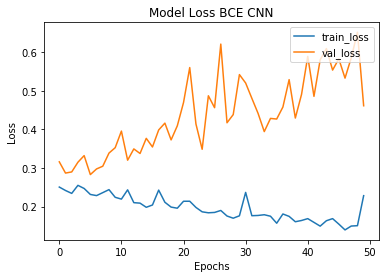

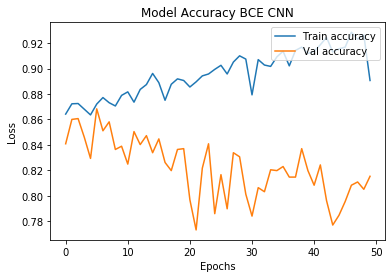

In [145]:
hist=model.fit(x_train, y_train, batch_size=64, epochs=50, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

                Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.869607    0.855660  0.862577     0.816117  0.790588   
Confirmed            0.706897    0.730693  0.718598     0.816117  0.790588   

                F1 micro  
False Positive  0.815335  
Confirmed       0.815335  


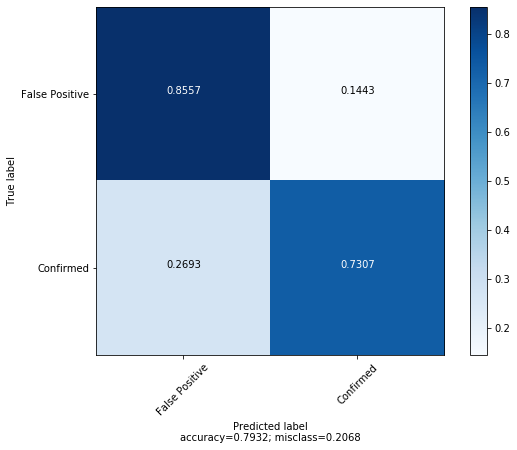

{'Precision raw': array([0.8696069 , 0.70689655]), 'Recall raw': array([0.85566038, 0.73069307]), 'F1 raw': array([0.86257727, 0.71859786]), 'F1 weighted': 0.816117460069127, 'F1 macro': 0.7905875642021112, 'F1 micro': 0.8153354632587859, 'Confusion Matrix': array([[907, 153],
       [136, 369]])}


In [146]:
predichos=model.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN'))

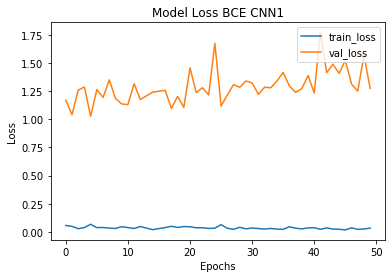

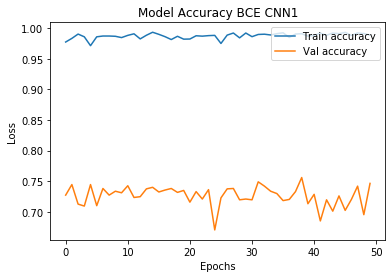

In [147]:
hist1=model1.fit(x_train, y_train, batch_size=64, epochs=50, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist1.history['loss'],label="train_loss")
plt.plot(hist1.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN1") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist1.history['acc'],label="Train accuracy" )
plt.plot(hist1.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN1") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

                Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.811268    0.815094  0.813176     0.745993  0.709076   
Confirmed            0.608000    0.601980  0.604975     0.745993  0.709076   

                F1 micro  
False Positive  0.746326  
Confirmed       0.746326  


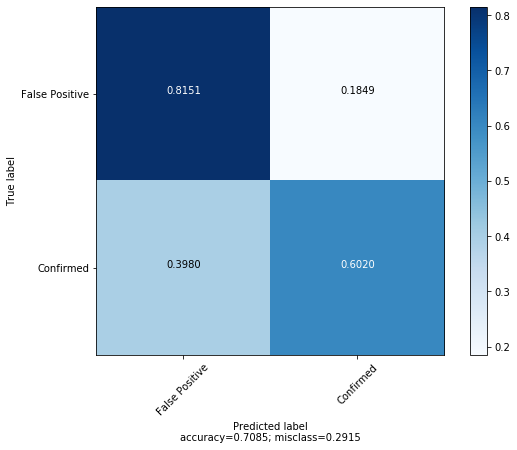

{'Precision raw': array([0.81126761, 0.608     ]), 'Recall raw': array([0.81509434, 0.6019802 ]), 'F1 raw': array([0.81317647, 0.60497512]), 'F1 weighted': 0.7459932885843289, 'F1 macro': 0.7090757974831724, 'F1 micro': 0.7463258785942491, 'Confusion Matrix': array([[864, 196],
       [201, 304]])}


In [148]:
predichos=model1.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1'))

In [22]:
def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

In [18]:
model2 = Sequential()
model2.add(Conv2D(64, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model2.add(MaxPooling2D((2,2)))
model2.add(Dropout(0.1))
model2.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model2.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="same"))
#model1.add(Flatten())
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(2, activation='softmax'))
model2.summary()

model2.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 15, 15, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
global_average_pooling2d_3 ( (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
__________

In [19]:
y_train_cat=to_categorical(y_train, 2)
y_train_cat[:3]
y_val_cat=to_categorical(y_val, 2)
y_val_cat[:3]

array([[0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

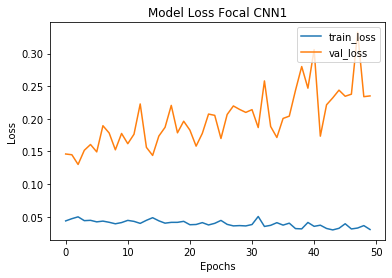

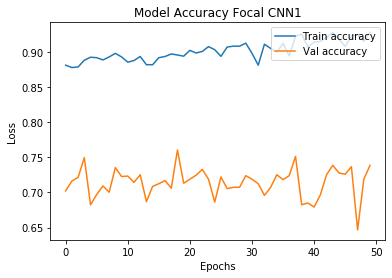

In [149]:
hist2=model2.fit(x_train, y_train_cat, batch_size=64, epochs=50, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist2.history['loss'],label="train_loss")
plt.plot(hist2.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN1") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist2.history['acc'],label="Train accuracy" )
plt.plot(hist2.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN1") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

                Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.851892    0.743396  0.793955     0.745178  0.718375   
Confirmed            0.575000    0.728713  0.642795     0.745178  0.718375   

                F1 micro  
False Positive  0.738658  
Confirmed       0.738658  


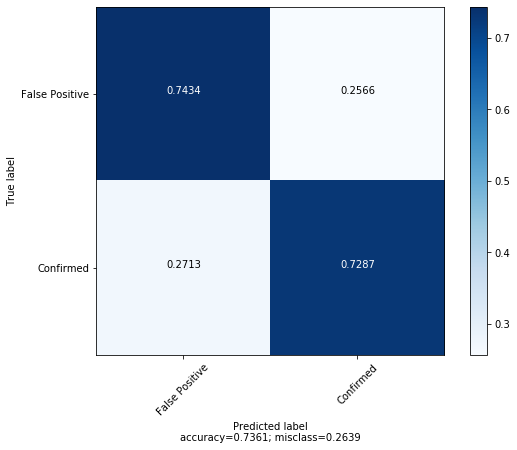

{'Precision raw': array([0.85189189, 0.575     ]), 'Recall raw': array([0.74339623, 0.72871287]), 'F1 raw': array([0.79395466, 0.64279476]), 'F1 weighted': 0.7451778231683003, 'F1 macro': 0.7183747098874749, 'F1 micro': 0.7386581469648562, 'Confusion Matrix': array([[788, 272],
       [137, 368]])}


In [150]:
predichos=model2.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1 Focal'))

# Segundo Modelo

In [25]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model3.add(Dropout(0.2))
model3.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model3.add(Dropout(0.1))
model3.add(GlobalAveragePooling2D())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(128,activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

model3.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 15, 15, 32)        320       
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
dropout_17 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
global_average_pooling2d_7 ( (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
__________

In [26]:
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model4.add(Dropout(0.2))
model4.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model4.add(Dropout(0.1))
model4.add(GlobalAveragePooling2D())
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(2, activation='softmax'))
model4.summary()
model4.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 15, 15, 32)        320       
_________________________________________________________________
dropout_19 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
dropout_20 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
global_average_pooling2d_8 ( (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
__________

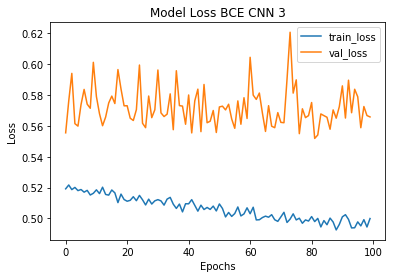

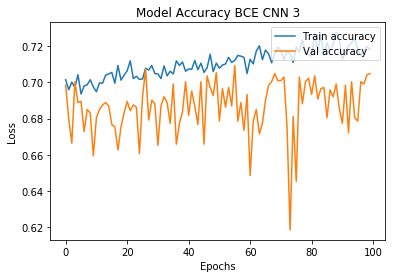

                F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.656462  0.704792  0.785316     0.702158       0.773810   
Confirmed       0.656462  0.704792  0.527607     0.702158       0.545455   

                Recall raw  
False Positive    0.797170  
Confirmed         0.510891  


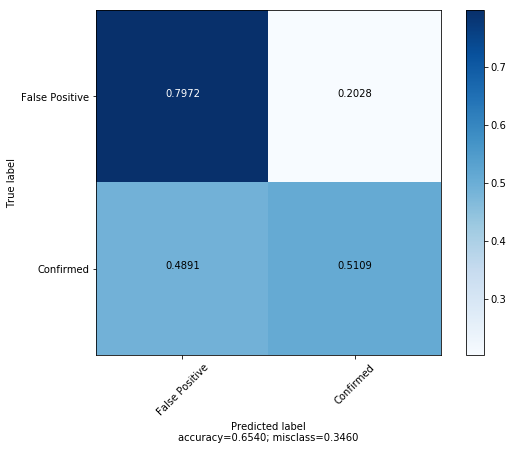

{'F1 macro': 0.6564616735466509, 'Recall raw': array([0.79716981, 0.51089109]), 'Confusion Matrix': array([[845, 215],
       [247, 258]]), 'Precision raw': array([0.77380952, 0.54545455]), 'F1 weighted': 0.7021576115203382, 'F1 micro': 0.7047923322683706, 'F1 raw': array([0.78531599, 0.52760736])}


In [29]:
hist3=model3.fit(x_train, y_train, batch_size=64, epochs=100, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist3.history['loss'],label="train_loss")
plt.plot(hist3.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 3") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist3.history['acc'],label="Train accuracy" )
plt.plot(hist3.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 3") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model3.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 3 BCE'))

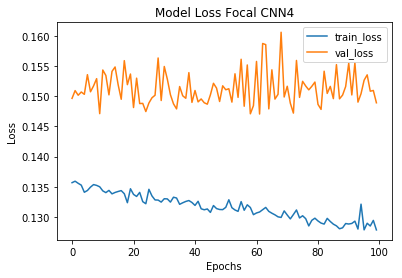

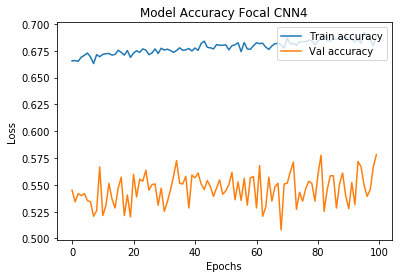

                F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.575654  0.578275  0.609005     0.587481       0.818471   
Confirmed       0.575654  0.578275  0.542302     0.587481       0.417289   

                Recall raw  
False Positive    0.484906  
Confirmed         0.774257  


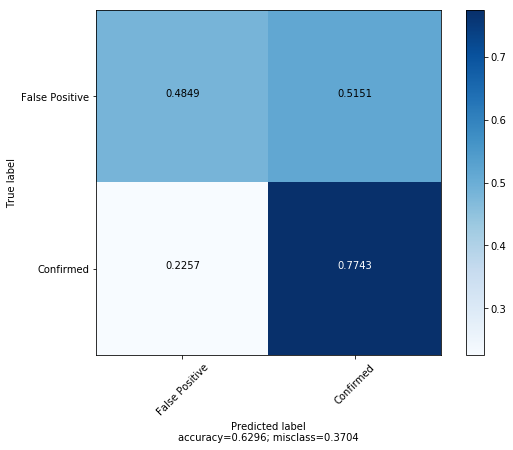

{'F1 macro': 0.5756535485864157, 'Recall raw': array([0.48490566, 0.77425743]), 'Confusion Matrix': array([[514, 546],
       [114, 391]]), 'Precision raw': array([0.81847134, 0.41728922]), 'F1 weighted': 0.5874809676703089, 'F1 micro': 0.5782747603833865, 'F1 raw': array([0.60900474, 0.54230236])}


In [30]:
hist4=model4.fit(x_train, y_train_cat, batch_size=64, epochs=100, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist4.history['loss'],label="train_loss")
plt.plot(hist4.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN4") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist4.history['acc'],label="Train accuracy" )
plt.plot(hist4.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN4") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model4.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1 Focal'))

In [38]:
model5 = Sequential()
model5.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model5.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model5.add(MaxPooling2D((2,2)))
model5.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model5.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model5.add(GlobalAveragePooling2D())
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(2, activation='softmax'))
model5.summary()
model5.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 15, 15, 16)        160       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 15, 15, 16)        2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
global_average_pooling2d_11  (None, 32)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               4224      
__________

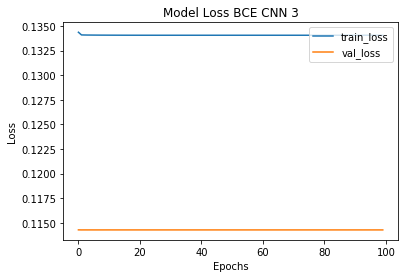

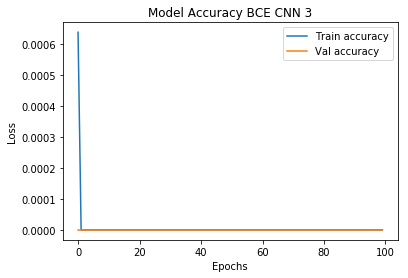

                F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.243961  0.322684  0.000000     0.157445       0.000000   
Confirmed       0.243961  0.322684  0.487923     0.157445       0.322684   

                Recall raw  
False Positive         0.0  
Confirmed              1.0  


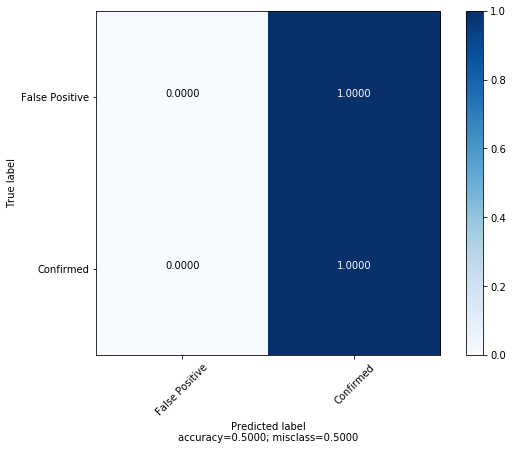

{'F1 macro': 0.2439613526570048, 'Recall raw': array([0., 1.]), 'Confusion Matrix': array([[   0, 1060],
       [   0,  505]]), 'Precision raw': array([0.        , 0.32268371]), 'F1 weighted': 0.15744470682656542, 'F1 micro': 0.3226837060702875, 'F1 raw': array([0.        , 0.48792271])}


In [39]:
hist5=model5.fit(x_train, y_train, batch_size=64, epochs=100, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist5.history['loss'],label="train_loss")
plt.plot(hist5.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 3") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()
plt.plot(hist5.history['acc'],label="Train accuracy" )
plt.plot(hist5.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 3") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()
predichos=model5.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 5 BCE'))

In [43]:
model6 = Sequential()
model6.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model6.add(BatchNormalization())
model6.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model6.add(BatchNormalization())
model6.add(MaxPooling2D((2,2)))

model6.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model6.add(BatchNormalization())
model6.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model6.add(BatchNormalization())

model6.add(GlobalAveragePooling2D())
model6.add(Dense(128, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.2))
model6.add(Dense(2, activation='softmax'))
model6.summary()
model6.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 15, 15, 16)        160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 15, 16)        64        
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 15, 15, 16)        2320      
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 15, 16)        64        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 32)          128       
__________

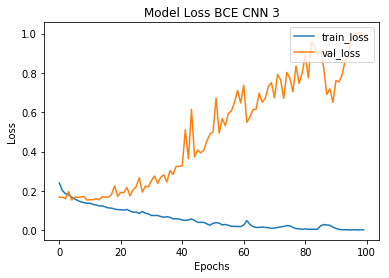

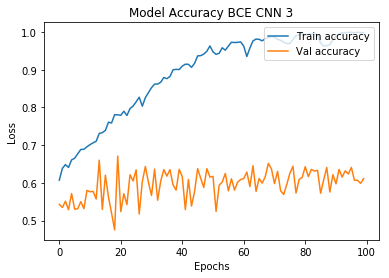

                F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.585637  0.611502  0.689162      0.62235       0.752232   
Confirmed       0.585637  0.611502  0.482112      0.62235       0.423019   

                Recall raw  
False Positive    0.635849  
Confirmed         0.560396  


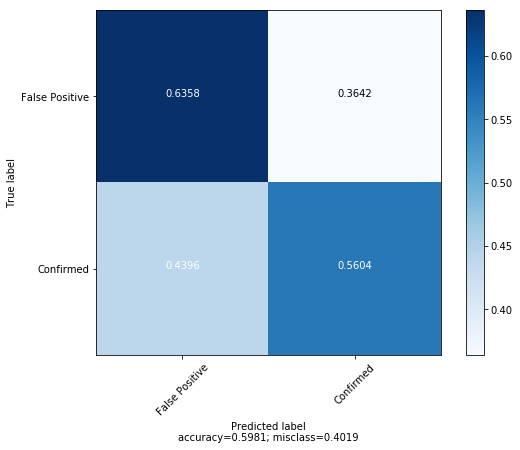

{'F1 macro': 0.5856369951540362, 'Recall raw': array([0.63584906, 0.56039604]), 'Confusion Matrix': array([[674, 386],
       [222, 283]]), 'Precision raw': array([0.75223214, 0.42301943]), 'F1 weighted': 0.6223501774327563, 'F1 micro': 0.6115015974440895, 'F1 raw': array([0.68916155, 0.48211244])}


In [44]:
hist6=model6.fit(x_train, y_train_cat, batch_size=128, epochs=100, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist6.history['loss'],label="train_loss")
plt.plot(hist6.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN 6") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist6.history['acc'],label="Train accuracy" )
plt.plot(hist6.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN 6") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model6.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 6 Focal'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 15, 15, 16)        160       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 15, 15, 16)        2320      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 32)          0         
__________

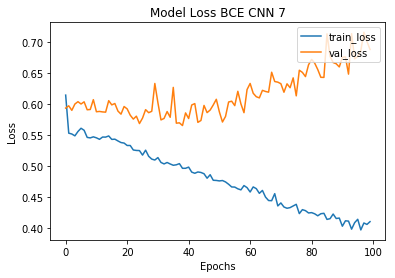

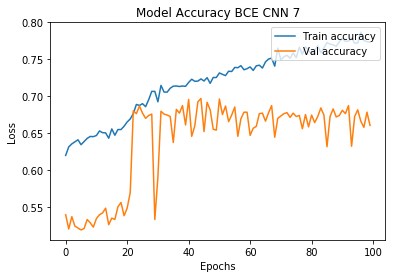

                F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.630743  0.660064  0.734796     0.667643       0.779070   
Confirmed       0.630743  0.660064  0.526690     0.667643       0.478191   

                Recall raw  
False Positive    0.695283  
Confirmed         0.586139  


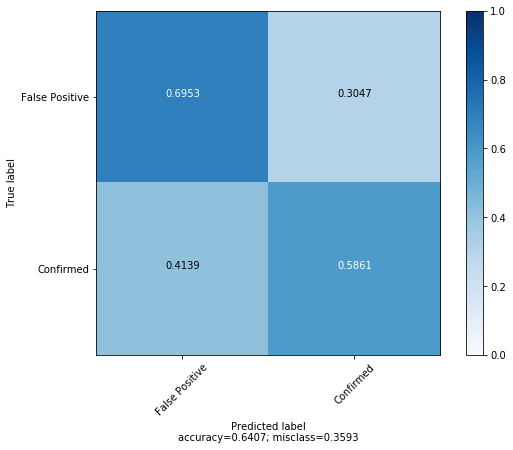

{'F1 macro': 0.6307430023097966, 'Recall raw': array([0.69528302, 0.58613861]), 'Confusion Matrix': array([[737, 323],
       [209, 296]]), 'Precision raw': array([0.77906977, 0.47819063]), 'F1 weighted': 0.6676434489693178, 'F1 micro': 0.6600638977635783, 'F1 raw': array([0.73479561, 0.52669039])}


In [25]:
model7 = Sequential()
model7.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model7.add(Conv2D(16, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.25))

#model7.add(Dropout(0.15))
model7.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.25))

model7.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
#model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.25))

model7.add(GlobalAveragePooling2D())
#model7.add(Dropout(0.15))
model7.add(Dense(1, activation='sigmoid'))
model7.summary()

model7.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

hist7=model7.fit(x_train, y_train, batch_size=128, epochs=100, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist7.history['loss'],label="train_loss")
plt.plot(hist7.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist7.history['acc'],label="Train accuracy" )
plt.plot(hist7.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model7.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 7 BCE'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 15, 15, 32)        320       
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 15, 15, 128)       73856     
_________________________________________________________________
global_average_pooling2d_5 ( (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
__________

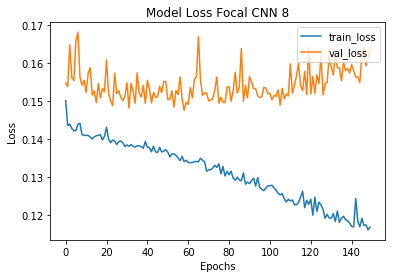

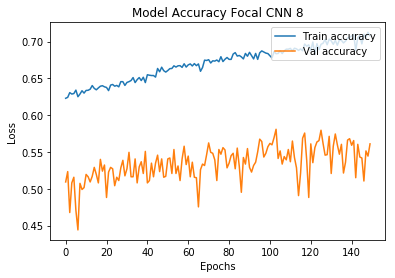

                F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.560537  0.561022  0.575139     0.565716       0.834829   
Confirmed       0.560537  0.561022  0.545935     0.565716       0.409722   

                Recall raw  
False Positive    0.438679  
Confirmed         0.817822  


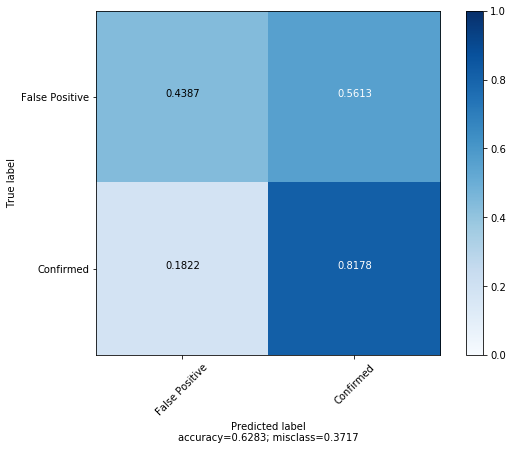

{'F1 macro': 0.5605371872957559, 'Recall raw': array([0.43867925, 0.81782178]), 'Confusion Matrix': array([[465, 595],
       [ 92, 413]]), 'Precision raw': array([0.83482944, 0.40972222]), 'F1 weighted': 0.5657155179001898, 'F1 micro': 0.5610223642172524, 'F1 raw': array([0.57513915, 0.54593523])}


In [21]:
model8 = Sequential()
model8.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model8.add(Dropout(0.15))
model8.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model8.add(Dropout(0.15))
model8.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model8.add(GlobalAveragePooling2D())
model8.add(Dense(256,activation='relu'))
model8.add(Dropout(0.3))
model8.add(Dense(128, activation='relu'))
model8.add(Dropout(0.15))
model8.add(Dense(2, activation='softmax'))
model8.summary()

model8.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

hist8=model8.fit(x_train, y_train_cat, batch_size=128, epochs=150, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist8.history['loss'],label="train_loss")
plt.plot(hist8.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN 8") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist8.history['acc'],label="Train accuracy" )
plt.plot(hist8.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN 8") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model8.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 150 epochs CNN 8 Focal'))

In [28]:
x_train.shape

(4692, 15, 15, 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 15, 32)            1472      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 15, 32)            3104      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 7, 32)             0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 7, 64)             6208      
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 7, 64)             12352     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 3, 64)             0         
__________

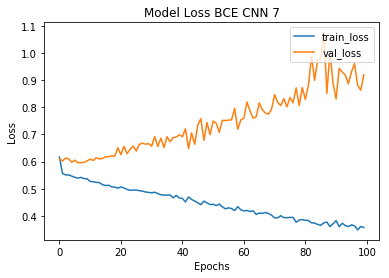

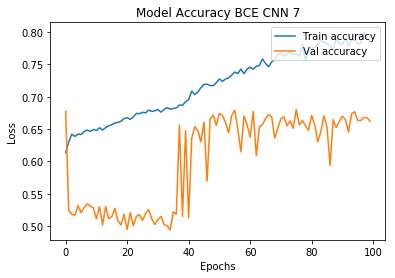

                F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.600958  0.661981  0.757005     0.656297       0.737690   
Confirmed       0.600958  0.661981  0.444911     0.656297       0.473214   

                Recall raw  
False Positive    0.777358  
Confirmed         0.419802  


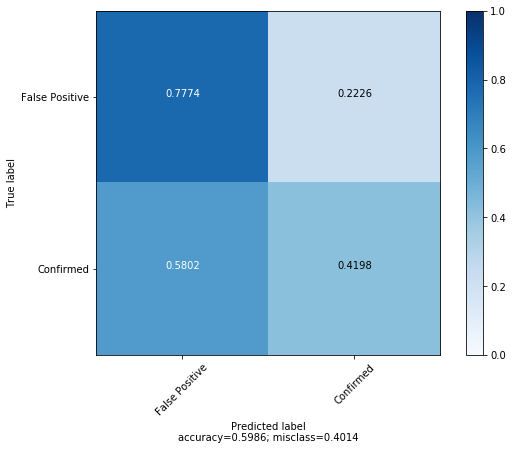

{'F1 macro': 0.6009579303999024, 'Recall raw': array([0.77735849, 0.41980198]), 'Confusion Matrix': array([[824, 236],
       [293, 212]]), 'Precision raw': array([0.73769024, 0.47321429]), 'F1 weighted': 0.6562973252535271, 'F1 micro': 0.6619808306709265, 'F1 raw': array([0.75700505, 0.44491081])}


In [33]:
model9 = Sequential()
model9.add(Conv1D(32, 3, input_shape=(15,15), strides=1,activation="relu", padding="same"))
model9.add(Conv1D(32, 3, strides=1, activation="relu", padding="same"))
model9.add(MaxPooling1D(2))
model9.add(Dropout(0.25))

#model7.add(Dropout(0.15))
model9.add(Conv1D(64, 3, strides=1, activation="relu", padding="same"))
model9.add(Conv1D(64, 3, strides=1, activation="relu", padding="same"))
model9.add(MaxPooling1D(2))
model9.add(Dropout(0.25))

model9.add(Conv1D(128, 3, strides=1, activation="relu", padding="same"))
model9.add(Conv1D(128, 3, strides=1, activation="relu", padding="same"))
#model7.add(MaxPooling2D((2,2)))
model9.add(Dropout(0.25))

model9.add(GlobalAveragePooling1D())
model9.add(Dense(128,activation='relu'))
model9.add(Dropout(0.5))
model9.add(Dense(1, activation='sigmoid'))
model9.summary()

model9.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

hist9=model9.fit(np.squeeze(x_train), y_train, batch_size=128, epochs=100, verbose=0, class_weight=class_weights, validation_data=(np.squeeze(x_val),y_val))
plt.plot(hist9.history['loss'],label="train_loss")
plt.plot(hist9.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist9.history['acc'],label="Train accuracy" )
plt.plot(hist9.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model9.predict_classes(np.squeeze(x_val))
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 9 BCE'))

# Gabo

In [18]:
model = Sequential()
model.add(Dropout(0.2, input_shape=(15,15,1)))
model.add(Conv2D(96, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(96, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(96, kernel_size=(3, 3), padding='same',activation='relu', strides=(2,2), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Conv2D(192, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(192, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(192, kernel_size=(3, 3), padding='same',activation='relu', strides = (2,2), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Conv2D(192, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(192, (1, 1), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(10, (1, 1), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

hist=model.fit(x_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, 
               class_weight=class_weights, 
               validation_data=(x_val,y_val)
              )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_7 (Dropout)          (None, 15, 15, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 96)        960       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 15, 15, 96)        83040     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 96)          83040     
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 8, 96)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 192)         166080    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 192)         331968    
__________

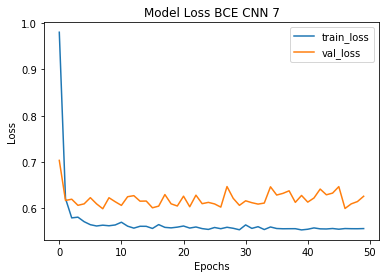

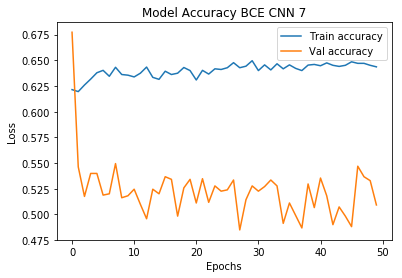

In [20]:
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

In [21]:
model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])

hist=model.fit(x_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, 
               class_weight=class_weights, 
               validation_data=(x_val,y_val)
              )

Train on 4692 samples, validate on 1565 samples
Epoch 1/50
4692/4692 [==============================] - 5s 1ms/step - loss: 0.5584 - acc: 0.6428 - val_loss: 0.6747 - val_acc: 0.4435
Epoch 2/50
4692/4692 [==============================] - 4s 914us/step - loss: 0.5601 - acc: 0.6417 - val_loss: 0.6184 - val_acc: 0.5220
Epoch 3/50
4692/4692 [==============================] - 4s 915us/step - loss: 0.5614 - acc: 0.6385 - val_loss: 0.6105 - val_acc: 0.5329
Epoch 4/50
4692/4692 [==============================] - 4s 915us/step - loss: 0.5564 - acc: 0.6370 - val_loss: 0.6056 - val_acc: 0.5361
Epoch 5/50
4692/4692 [==============================] - 4s 933us/step - loss: 0.5601 - acc: 0.6398 - val_loss: 0.6638 - val_acc: 0.4684
Epoch 6/50
4692/4692 [==============================] - 4s 932us/step - loss: 0.5578 - acc: 0.6479 - val_loss: 0.5989 - val_acc: 0.5553
Epoch 7/50
4692/4692 [==============================] - 4s 923us/step - loss: 0.5595 - acc: 0.6379 - val_loss: 0.6021 - val_acc: 0.5399
Ep

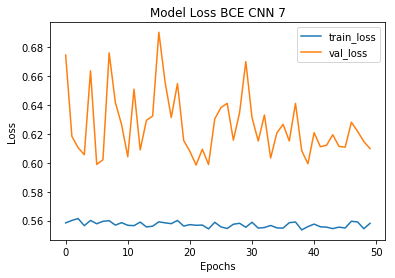

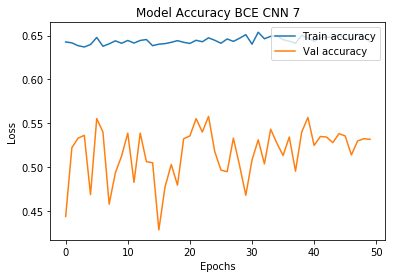

In [23]:
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

In [29]:
x_train.shape

(4692, 15, 15, 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_40 (Dropout)         (None, 15, 15, 1)         0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 15, 15, 96)        960       
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 15, 15, 96)        83040     
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 8, 8, 96)          83040     
_________________________________________________________________
dropout_41 (Dropout)         (None, 8, 8, 96)          0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 8, 8, 192)         166080    
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 8, 8, 192)         331968    
__________

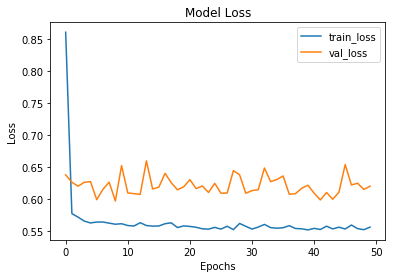

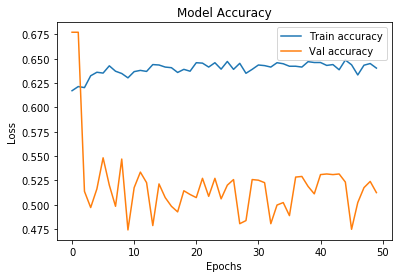

In [38]:
model = Sequential()
model.add(Dropout(0.2, input_shape=(15,15,1)))
model.add(Conv2D(96, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(96, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(96, (3, 3), padding='same',activation='relu', strides=(2,2), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Conv2D(192, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(192, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(192, (3, 3), padding='same',activation='relu', strides = (2,2), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Conv2D(192, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(192, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(10, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

hist=model.fit(x_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, 
               class_weight=class_weights, 
               validation_data=(x_val,y_val)
              )


plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_249 (Conv2D)          (None, 15, 15, 64)        640       
_________________________________________________________________
conv2d_250 (Conv2D)          (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_87 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_251 (Conv2D)          (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_252 (Conv2D)          (None, 7, 7, 128)         147584    
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 3, 3, 128)         0         
__________

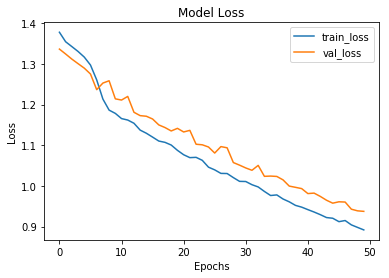

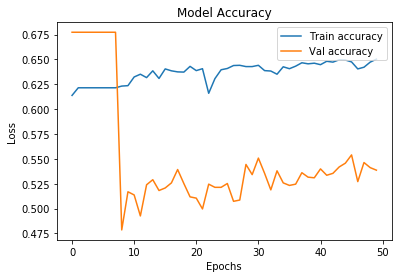

                Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.868996    0.375472  0.524374     0.533324  0.538242   
Confirmed            0.401987    0.881188  0.552109     0.533324  0.538242   

                F1 micro  
False Positive  0.538658  
Confirmed       0.538658  


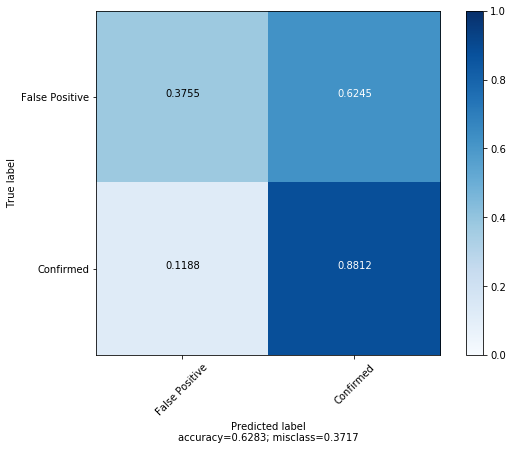

{'Precision raw': array([0.86899563, 0.40198735]), 'Recall raw': array([0.3754717 , 0.88118812]), 'F1 raw': array([0.52437418, 0.55210918]), 'F1 weighted': 0.533323810618148, 'F1 macro': 0.5382416788447644, 'F1 micro': 0.5386581469648563, 'Confusion Matrix': array([[398, 662],
       [ 60, 445]])}


In [74]:
model = Sequential()
model.add(Conv2D(64, 3, input_shape=(15,15,1), strides=1,activation="relu", padding="same",kernel_regularizer=l2(0.001)))
model.add(Conv2D(64, 3, strides=1, activation="relu", padding="same",kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, strides=1, activation="relu", padding="same",kernel_regularizer=l2(0.001)))
model.add(Conv2D(128, 3, strides=1, activation="relu", padding="same",kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, 3, strides=1, activation="relu", padding="same",kernel_regularizer=l2(0.001)))
model.add(Conv2D(256, 3, strides=1, activation="relu", padding="same",kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer=SGD(lr=0.01, momentum=0.9),metrics=['acc'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.0001)
hist=model.fit(x_train, y_train,
               batch_size=128, 
               epochs=50, 
               verbose=0, 
               class_weight=class_weights, 
               callbacks=[reduce_lr],
               validation_data=(x_val,y_val)
              )

plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model.predict_classes(x_val)
print(calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 9 BCE'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_273 (Conv2D)          (None, 15, 15, 64)        640       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_105 (Dropout)        (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_274 (Conv2D)          (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_275 (Conv2D)          (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 3, 3, 256)         0         
_________________________________________________________________
global_average_pooling2d_39  (None, 256)               0         
__________

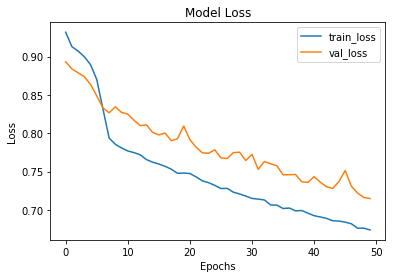

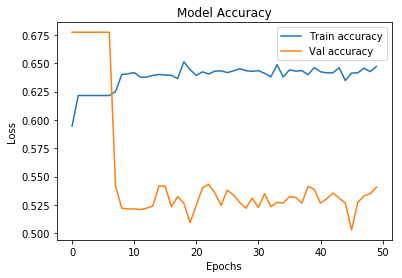

                Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.818692    0.413208  0.549216     0.543531  0.540406   
Confirmed            0.396117    0.807921  0.531596     0.543531  0.540406   

                F1 micro  
False Positive  0.540575  
Confirmed       0.540575  


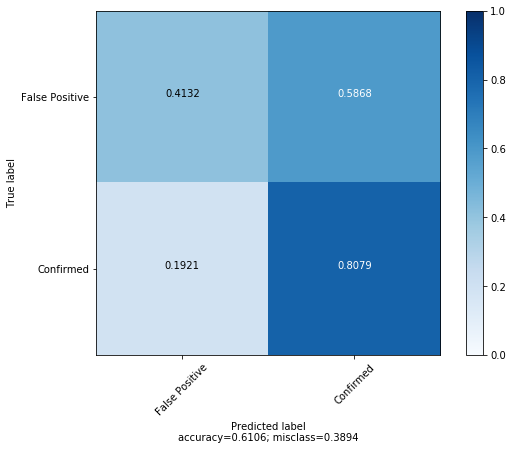

{'Precision raw': array([0.81869159, 0.3961165 ]), 'Recall raw': array([0.41320755, 0.80792079]), 'F1 raw': array([0.5492163 , 0.53159609]), 'F1 weighted': 0.54353054636134, 'F1 macro': 0.5404061960728253, 'F1 micro': 0.5405750798722044, 'Confusion Matrix': array([[438, 622],
       [ 97, 408]])}


In [81]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same",kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same",kernel_regularizer=l2(0.001)))
model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="same",kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2,2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer=SGD(lr=0.01, momentum=0.9),metrics=['acc'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.0001)
hist=model.fit(x_train, y_train,
               batch_size=128, 
               epochs=50, 
               verbose=0, 
               class_weight=class_weights, 
               validation_data=(x_val,y_val)
              )

plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model.predict_classes(x_val)
print(calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 9 BCE'))